Epoch 1, Loss: 0.0870155394077301
Epoch 2, Loss: 0.07786594331264496
Epoch 3, Loss: 0.07776126265525818
Epoch 4, Loss: 0.07529061287641525
Epoch 5, Loss: 0.07594902813434601


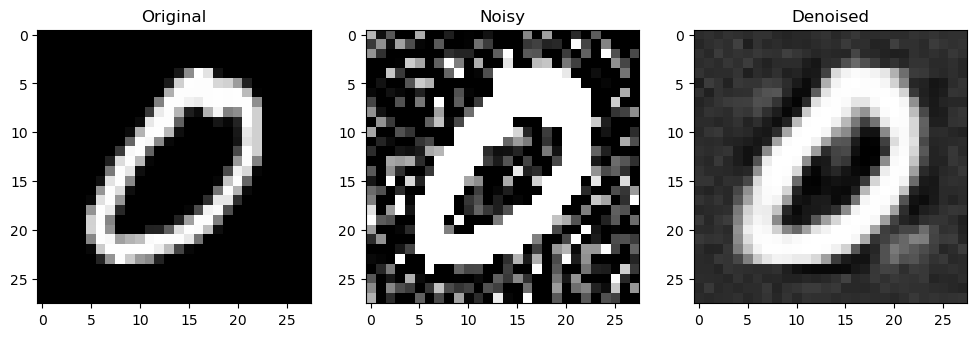

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os

# 定义去噪自编码器
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 定义 MNIST 数据集类
class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = self.load_images(images_path)
        self.labels = self.load_labels(labels_path)
        self.transform = transform

    def load_images(self, path):
        with open(path, 'rb') as f:
            f.read(16)  # 跳过前16个字节
            images = np.frombuffer(f.read(), np.uint8).reshape(-1, 1, 28, 28)
        return torch.tensor(images, dtype=torch.float32).view(-1, 784)  # Flatten images

    def load_labels(self, path):
        with open(path, 'rb') as f:
            f.read(8)  # 跳过前8个字节
            labels = np.frombuffer(f.read(), np.uint8)
        return labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# 数据准备
data_root = r'C:\Users\honor\Desktop\Python入门\模型\ddpm\data\MNIST\raw'
train_dataset = MNISTDataset(
    images_path=os.path.join(data_root, 'train-images-idx3-ubyte'),
    labels_path=os.path.join(data_root, 'train-labels-idx1-ubyte')
)

test_dataset = MNISTDataset(
    images_path=os.path.join(data_root, 't10k-images-idx3-ubyte'),
    labels_path=os.path.join(data_root, 't10k-labels-idx1-ubyte')
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 模型、损失函数和优化器
model = DenoisingAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 可视化函数
def show_images(original, noisy, denoised):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(original.view(28, 28).detach().numpy(), cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title("Noisy")
    plt.imshow(noisy.view(28, 28).detach().numpy(), cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title("Denoised")
    plt.imshow(denoised.view(28, 28).detach().numpy(), cmap='gray')
    
    plt.show()

# 训练模型
for epoch in range(5):
    for data, _ in train_loader:
        optimizer.zero_grad()
        noisy_data = data + 0.5 * torch.randn_like(data)  # 添加噪声
        noisy_data = torch.clamp(noisy_data, 0., 1.)
        
        output = model(noisy_data)
        
        loss = criterion(output, noisy_data)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

# 可视化原始、带噪声和去噪后的图片
test_data, _ = next(iter(train_loader))
noisy_test_data = test_data + 0.5 * torch.randn_like(test_data)
noisy_test_data = torch.clamp(noisy_test_data, 0., 1.)
denoised_output = model(noisy_test_data)

# 显示图像
show_images(test_data[0], noisy_test_data[0], denoised_output[0])